In [137]:
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from segment_anything import sam_model_registry, SamPredictor

import cv2, os
from time import perf_counter
import torch
import numpy as np
from imantics import Mask, Polygons
import matplotlib.pyplot as plt

In [138]:
# %reset

In [139]:
# from plot_bbox import draw_bbox, show_mask, show_box

def draw_bbox(source_img, boxes, labels, fname, prob):
    draw = ImageDraw.Draw(source_img)
    print(boxes)
    print(labels)
    print(prob)
    #font = ImageFont.truetype("arial.ttf", 50)
    font = ImageFont.load_default()
    k = 0
    for i in range(len(boxes)):
        draw.rectangle(((boxes[i][0], boxes[i][1]), (boxes[i][0]+boxes[i][2], boxes[i][1]+boxes[i][3])), outline="white", width = 10)
        draw.text((boxes[i][0], boxes[i][1]), labels[k]+": " +str(prob[k]), font = font, fill = "white", align = "center", stroke_width = 1) 
        k += 1
    source_img.save("results/pred_{}".format(fname))
    
def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=(0,225,225), facecolor=(0,0,0,0), lw=2))
    ax.text(x0, y0+7, label, fontsize = 10, color ="white")

In [174]:
from glob import glob
import os
ImagesList = glob("")
JSONList = glob("")

In [180]:
import json
JSONImageData = json.load(open(JSONList[8],"r"))
# JSONImageData

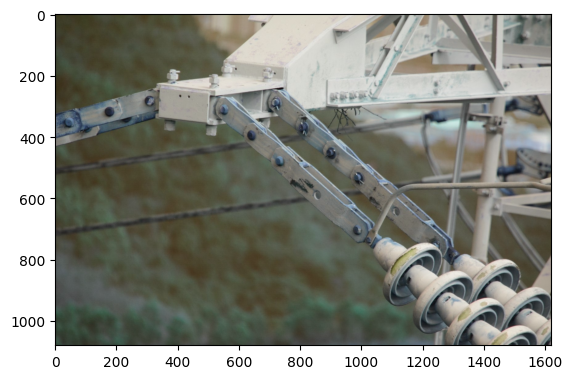

In [182]:
image = cv2.imread(JSONList[8].replace("json","JPG"))
plt.imshow(image)

In [183]:
def GetBBox(poly):
    x_coordinates = [point[0] for point in poly]
    y_coordinates = [point[1] for point in poly]
    
    x_min = min(x_coordinates)
    x_max = max(x_coordinates)
    y_min = min(y_coordinates)
    y_max = max(y_coordinates)
    
    coco_bbox = [x_min, y_min, x_max, y_max]
    
    return coco_bbox

In [184]:
# from segment_anything import SamAutomaticMaskGenerator

# class OpenCVSAM:
    
#     def __init__(self,model_path):
#         self.model_path = model_path
#         self.sam = sam_model_registry["vit_h"](checkpoint = model_path)
#         self.sam.to(device = "cuda")
#         self.mask_generator = SamAutomaticMaskGenerator(self.sam)
#         self.predictor = SamPredictor(self.sam)
        
#     def GetPolygon(self,result):
#         contours = []

#         for ind in range(len(result)):
#             # Assuming the result is a list of dictionaries and 'segmentation' key contains the segmentation mask
#             segmentation_mask = result[ind]['segmentation']

#             # Convert the segmentation mask to a binary mask
#             segmentation_mask = np.uint8(segmentation_mask) * 255

#             # # Find contours in the binary mask
#             contour, _ = cv2.findContours(segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#             contours.append(contour[0])

#         return contours
        
#     def GenerateMaskGetPolygoan(self,image_path):
#         image_bgr = cv2.imread(image_path)
#         image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#         result = self.mask_generator.generate(image_rgb)
#         polygoan = self.GetPolygon(result)
#         return polygoan
    
# Objs = OpenCVSAM("../PipelineDevelopment/sam_vit_h_4b8939.pth")

In [185]:
# annotation box list

AnnotBBox=[]

for ind in range(len(JSONImageData['shapes'])):
    if len(JSONImageData['shapes'][ind]['points'][ind]) == 4:
        AnnotBBox.append(JSONImageData['shapes'][ind]['points'])
    else:
        AnnotBBox.append(GetBBox(np.array(JSONImageData['shapes'][ind]['points']).astype("int32")))

In [186]:
image_path = JSONList[8].replace("json","JPG")

sam_checkpoint = "../PipelineDevelopment/sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

image = cv2.imread(image_path)
predictor.set_image(image)

Masks = []
BBox = []

for ind in range(len(AnnotBBox)):
    input_box = np.array(AnnotBBox[ind])
    masks, scores, logits = predictor.predict(
        box=input_box,
        multimask_output=False
    )
    
    Masks.append(masks)
    BBox.append(input_box)

In [187]:
def MaskToPolygon(masks):
    mask_np = masks.squeeze()
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask_np.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw the contours for visualization
    contour_image = np.zeros_like(mask_np, dtype=np.uint8)

    # List to store coordinates
    coordinates_list = []

    # Loop through the contours and extract coordinates
    for contour in contours:
        # Get the coordinates of the contour points
        contour_points = contour.reshape(-1, 2)

        # Append the contour points to the coordinates list
        coordinates_list.extend(contour_points.tolist())

        # Draw the contour on the empty image
        cv2.drawContours(contour_image, [contour], 0, 255, 1)
        
        
    return coordinates_list

In [188]:
Polygoan = [MaskToPolygon(Masks[ind]) for ind in range(len(Masks))]

In [170]:
# Polygoan

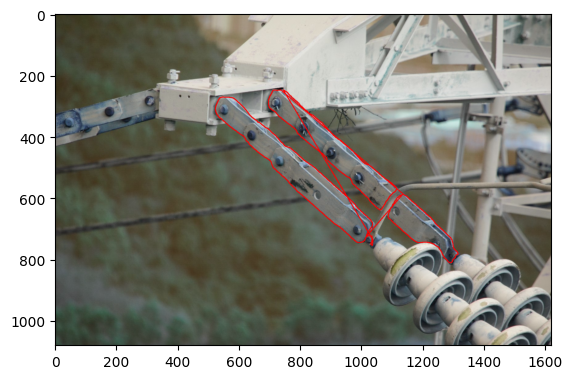

In [189]:
image = cv2.imread(image_path)
for ind in range(len(Polygoan)):
    pts = np.reshape(Polygoan[ind],(-1, 1, 2))
    image = cv2.polylines(image, [pts],True, (255, 0, 0), 2)
plt.imshow(image)

In [191]:
len(Polygoan)

2

### Yash Code

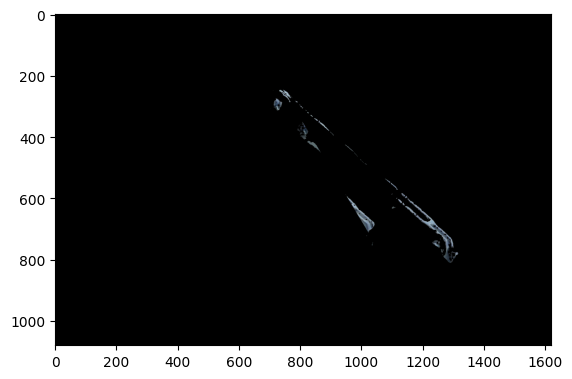

In [196]:
import cv2
import os
import numpy as np

# Load the image
image_path = image_path
image = cv2.imread(image_path)

# Create a blank mask image
mask = np.zeros_like(image)

for ind in range(len(Polygoan)):

    # Define the polygon or bounding box coordinates
    # You should replace these with your actual coordinates

    polygon_coordinates_tuples = [tuple(point) for point in Polygoan[ind]]

    polygon_coordinates = polygon_coordinates_tuples

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper HSV values for darker brown colors (including black)
    lower_brown = np.array([10, 30, 30])  # Adjust these values as needed
    upper_brown = np.array([30, 255, 255])  # Adjust these values as needed

    # Create a mask for the brown color range on the blank mask image
    mask = cv2.inRange(hsv_image, lower_brown, upper_brown)

    # Create a mask for the specified region (polygon or bounding box) on the blank mask image
    region_mask = np.zeros_like(mask)
    cv2.fillPoly(region_mask, [np.array(polygon_coordinates)], 255)

    # Combine the masks for brown color and the specified region on the blank mask image
    corrosion_mask = cv2.bitwise_and(mask, region_mask)

    # Apply the corrosion mask to the original image
    result_image = cv2.bitwise_and(image, image, mask=corrosion_mask)

plt.imshow(result_image)

In [12]:
sam_checkpoint = "../PipelineDevelopment/sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

image = cv2.imread(image_path)
predictor.set_image(image)

data = GetMasksAndBoxes(predictor, BBox_Lists)

In [34]:
Polygoan = [MaskToPolygon(data['Masks'][ind]) for ind in range(len(data['Masks']))]

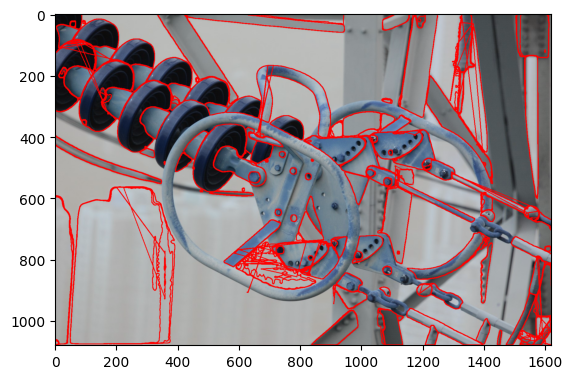

In [44]:
image = cv2.imread(image_path)

for ind in range(len(Polygoan)):
    pts = np.reshape(Polygoan[ind],(-1, 1, 2)).astype("int32")
    image = cv2.polylines(image, [pts],True, (255, 0, 0), 2)
plt.imshow(image)